# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [13]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

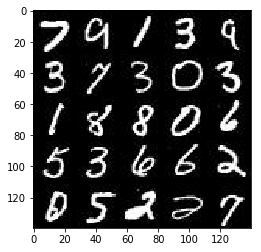

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

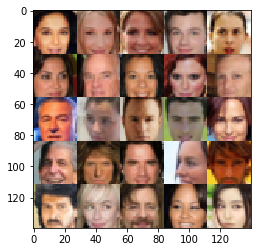

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [17]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32,(None, image_width, image_height, image_channels), name = "input")
    z_input = tf.placeholder(tf.float32, (None,z_dim), name="z_input")
    learning_rate = tf.placeholder(tf.float32, name = "learning_rate")
    return input_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [71]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #print(images.shape)
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        print(x3.shape)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, [-1, 4*4*256])
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

(?, 4, 4, 256)
(?, 4, 4, 256)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [72]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        #fully connected layer
        layer1 = tf.layers.dense(z, 4*4*512)
        
        layer1 = tf.reshape(layer1, (-1,4,4,512))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(alpha*layer1,layer1)
        print(layer1.shape)
        #4x4x512
        
        layer2 = tf.layers.conv2d_transpose(layer1,256,4,strides=1,padding='valid')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha*layer2,layer2)
        print(layer2.shape)
        #7x7x256
        
        layer3 = tf.layers.conv2d_transpose(layer2,128,4,strides=2,padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha*layer3,layer3)
        #14x14x128
        print(layer3.shape)
        
        #layer3 = tf.layers.conv2d_transpose(layer2,64,5,strides=2,padding='same')
        #layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        #layer3 = tf.maximum(alpha*layer3,layer3)
        #print(layer3.shape)
        #28x28x128
        
        logits = tf.layers.conv2d_transpose(layer3,out_channel_dim,4,strides=2,padding='same')
        print(logits.shape)
        
        out = tf.tanh(logits)
        #print(out)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 5)
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [73]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_real_logits = discriminator(input_real)
    d_model_fake, d_fake_logits = discriminator(g_model,reuse=True)
    
    print(d_model_real)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_real_logits,labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_fake_logits,labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_fake_logits, labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 4)
(?, 4, 4, 256)
(?, 4, 4, 256)
Tensor("discriminator/Sigmoid:0", shape=(?, 1), dtype=float32)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [74]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [75]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [76]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    out_channel_dim = image_channels
    
    steps = 0
        
    #tf.reset_default_graph()
    print(z_dim)
    input_real, input_z, lrate = model_inputs(image_width,image_height,image_channels,z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
                
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                #print(steps)
                steps += 1
                batch_images = batch_images*2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images,input_z: batch_z,lrate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,input_z: batch_z,lrate:learning_rate})

                if steps %10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps%100 == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

100
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)
(?, 4, 4, 256)
(?, 4, 4, 256)
Tensor("discriminator/Sigmoid:0", shape=(?, 1), dtype=float32)
Epoch 1/2... Discriminator Loss: 0.2822... Generator Loss: 2.1048
Epoch 1/2... Discriminator Loss: 0.2104... Generator Loss: 6.3914
Epoch 1/2... Discriminator Loss: 0.1159... Generator Loss: 4.8492
Epoch 1/2... Discriminator Loss: 0.0027... Generator Loss: 10.3598
Epoch 1/2... Discriminator Loss: 0.2041... Generator Loss: 4.6014
Epoch 1/2... Discriminator Loss: 0.2363... Generator Loss: 10.0083
Epoch 1/2... Discriminator Loss: 0.4006... Generator Loss: 10.2844
Epoch 1/2... Discriminator Loss: 1.9588... Generator Loss: 0.1849
Epoch 1/2... Discriminator Loss: 0.3492... Generator Loss: 9.1567
Epoch 1/2... Discriminator Loss: 0.2381... Generator Loss: 4.4425
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


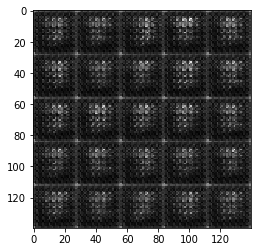

Epoch 1/2... Discriminator Loss: 0.6174... Generator Loss: 1.1483
Epoch 1/2... Discriminator Loss: 0.3559... Generator Loss: 2.5161
Epoch 1/2... Discriminator Loss: 0.2860... Generator Loss: 2.5862
Epoch 1/2... Discriminator Loss: 0.1480... Generator Loss: 3.2231
Epoch 1/2... Discriminator Loss: 0.1638... Generator Loss: 2.8980
Epoch 1/2... Discriminator Loss: 0.1807... Generator Loss: 2.4166
Epoch 1/2... Discriminator Loss: 0.4024... Generator Loss: 5.8650
Epoch 1/2... Discriminator Loss: 1.1393... Generator Loss: 2.2563
Epoch 1/2... Discriminator Loss: 0.7258... Generator Loss: 2.8850
Epoch 1/2... Discriminator Loss: 0.7728... Generator Loss: 1.1765
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


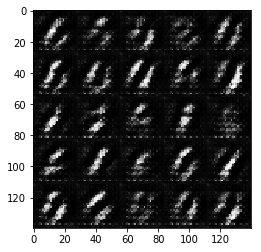

Epoch 1/2... Discriminator Loss: 0.6201... Generator Loss: 1.2344
Epoch 1/2... Discriminator Loss: 0.3109... Generator Loss: 2.1458
Epoch 1/2... Discriminator Loss: 0.6042... Generator Loss: 1.0635
Epoch 1/2... Discriminator Loss: 0.4511... Generator Loss: 1.9708
Epoch 1/2... Discriminator Loss: 0.7139... Generator Loss: 2.2622
Epoch 1/2... Discriminator Loss: 0.7133... Generator Loss: 1.2370
Epoch 1/2... Discriminator Loss: 0.9004... Generator Loss: 0.7768
Epoch 1/2... Discriminator Loss: 0.7737... Generator Loss: 1.2522
Epoch 1/2... Discriminator Loss: 0.9276... Generator Loss: 1.3823
Epoch 1/2... Discriminator Loss: 0.9148... Generator Loss: 1.0864
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


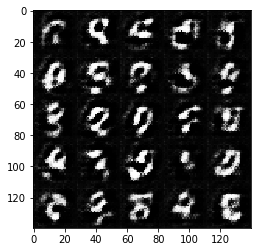

Epoch 1/2... Discriminator Loss: 0.8408... Generator Loss: 0.9561
Epoch 1/2... Discriminator Loss: 0.7929... Generator Loss: 0.9859
Epoch 1/2... Discriminator Loss: 0.4170... Generator Loss: 2.0229
Epoch 1/2... Discriminator Loss: 0.5898... Generator Loss: 1.7533
Epoch 1/2... Discriminator Loss: 0.7353... Generator Loss: 2.4452
Epoch 1/2... Discriminator Loss: 0.9096... Generator Loss: 0.8954
Epoch 1/2... Discriminator Loss: 1.3802... Generator Loss: 2.6882
Epoch 1/2... Discriminator Loss: 1.0820... Generator Loss: 2.3728
Epoch 1/2... Discriminator Loss: 1.0113... Generator Loss: 1.1452
Epoch 1/2... Discriminator Loss: 0.8383... Generator Loss: 0.9815
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


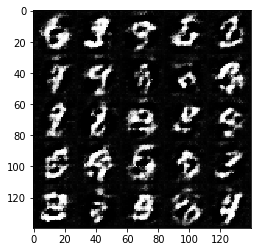

Epoch 1/2... Discriminator Loss: 1.3536... Generator Loss: 0.4140
Epoch 1/2... Discriminator Loss: 1.1708... Generator Loss: 0.5298
Epoch 1/2... Discriminator Loss: 1.2700... Generator Loss: 0.4779
Epoch 1/2... Discriminator Loss: 0.6961... Generator Loss: 1.1857
Epoch 1/2... Discriminator Loss: 0.7915... Generator Loss: 1.1081
Epoch 1/2... Discriminator Loss: 0.9242... Generator Loss: 0.8728
Epoch 1/2... Discriminator Loss: 0.8819... Generator Loss: 0.7564
Epoch 1/2... Discriminator Loss: 0.7759... Generator Loss: 1.9866
Epoch 1/2... Discriminator Loss: 1.1630... Generator Loss: 2.2700
Epoch 1/2... Discriminator Loss: 0.7789... Generator Loss: 1.5364
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


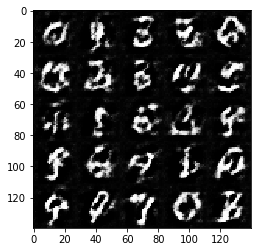

Epoch 1/2... Discriminator Loss: 0.5808... Generator Loss: 1.6775
Epoch 1/2... Discriminator Loss: 0.7721... Generator Loss: 1.6738
Epoch 1/2... Discriminator Loss: 0.8973... Generator Loss: 0.7038
Epoch 1/2... Discriminator Loss: 0.7016... Generator Loss: 1.0779
Epoch 1/2... Discriminator Loss: 0.6610... Generator Loss: 2.0928
Epoch 1/2... Discriminator Loss: 0.7415... Generator Loss: 1.9143
Epoch 1/2... Discriminator Loss: 0.8555... Generator Loss: 1.1418
Epoch 1/2... Discriminator Loss: 0.6400... Generator Loss: 1.3478
Epoch 1/2... Discriminator Loss: 0.8065... Generator Loss: 0.9029
Epoch 1/2... Discriminator Loss: 0.9662... Generator Loss: 1.9265
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


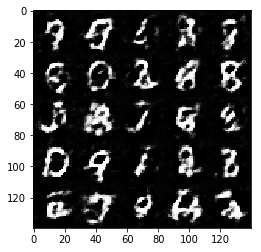

Epoch 1/2... Discriminator Loss: 0.5112... Generator Loss: 1.4547
Epoch 1/2... Discriminator Loss: 0.6995... Generator Loss: 1.0524
Epoch 1/2... Discriminator Loss: 0.7634... Generator Loss: 1.7181
Epoch 1/2... Discriminator Loss: 0.6737... Generator Loss: 1.4525
Epoch 1/2... Discriminator Loss: 1.0595... Generator Loss: 0.6054
Epoch 1/2... Discriminator Loss: 0.9152... Generator Loss: 0.7400
Epoch 1/2... Discriminator Loss: 0.9384... Generator Loss: 0.7218
Epoch 1/2... Discriminator Loss: 0.7995... Generator Loss: 1.2846
Epoch 1/2... Discriminator Loss: 0.7241... Generator Loss: 1.7976
Epoch 1/2... Discriminator Loss: 0.7818... Generator Loss: 1.7581
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


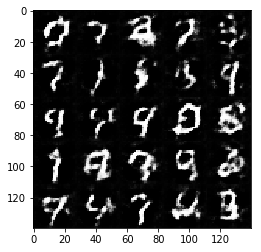

Epoch 1/2... Discriminator Loss: 0.7125... Generator Loss: 1.7059
Epoch 1/2... Discriminator Loss: 0.8935... Generator Loss: 0.8210
Epoch 1/2... Discriminator Loss: 0.7310... Generator Loss: 1.0131
Epoch 1/2... Discriminator Loss: 0.7497... Generator Loss: 2.4761
Epoch 1/2... Discriminator Loss: 0.9951... Generator Loss: 0.6188
Epoch 1/2... Discriminator Loss: 0.8686... Generator Loss: 0.9413
Epoch 1/2... Discriminator Loss: 0.6838... Generator Loss: 1.8038
Epoch 1/2... Discriminator Loss: 1.3672... Generator Loss: 0.3893
Epoch 1/2... Discriminator Loss: 0.8687... Generator Loss: 1.8217
Epoch 1/2... Discriminator Loss: 0.7506... Generator Loss: 1.6911
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


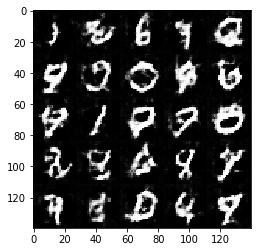

Epoch 1/2... Discriminator Loss: 0.9623... Generator Loss: 0.6821
Epoch 1/2... Discriminator Loss: 0.7516... Generator Loss: 0.8317
Epoch 1/2... Discriminator Loss: 1.0130... Generator Loss: 0.5878
Epoch 1/2... Discriminator Loss: 1.5697... Generator Loss: 0.2991
Epoch 1/2... Discriminator Loss: 0.7315... Generator Loss: 1.2472
Epoch 1/2... Discriminator Loss: 1.7129... Generator Loss: 0.2392
Epoch 1/2... Discriminator Loss: 0.7085... Generator Loss: 1.0668
Epoch 1/2... Discriminator Loss: 0.8651... Generator Loss: 2.1815
Epoch 1/2... Discriminator Loss: 0.8366... Generator Loss: 0.8416
Epoch 1/2... Discriminator Loss: 0.6895... Generator Loss: 1.1296
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


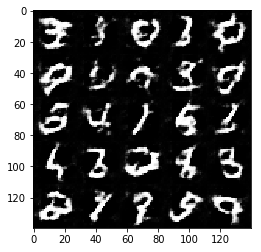

Epoch 1/2... Discriminator Loss: 0.7766... Generator Loss: 0.8897
Epoch 1/2... Discriminator Loss: 0.8972... Generator Loss: 0.7800
Epoch 1/2... Discriminator Loss: 0.8936... Generator Loss: 2.1651
Epoch 1/2... Discriminator Loss: 0.7306... Generator Loss: 1.5765
Epoch 1/2... Discriminator Loss: 0.8944... Generator Loss: 1.0496
Epoch 1/2... Discriminator Loss: 0.9460... Generator Loss: 0.7082
Epoch 1/2... Discriminator Loss: 1.3025... Generator Loss: 0.4580
Epoch 1/2... Discriminator Loss: 0.7521... Generator Loss: 1.3329
Epoch 1/2... Discriminator Loss: 1.3743... Generator Loss: 0.3775
Epoch 1/2... Discriminator Loss: 1.0703... Generator Loss: 0.6404
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


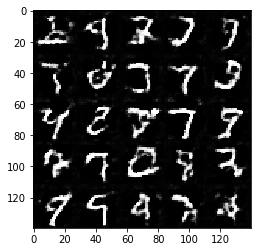

Epoch 1/2... Discriminator Loss: 0.5035... Generator Loss: 1.5569
Epoch 1/2... Discriminator Loss: 0.7751... Generator Loss: 0.9881
Epoch 1/2... Discriminator Loss: 0.6505... Generator Loss: 1.2974
Epoch 1/2... Discriminator Loss: 0.7504... Generator Loss: 0.9227
Epoch 1/2... Discriminator Loss: 1.1326... Generator Loss: 0.4924
Epoch 1/2... Discriminator Loss: 0.7768... Generator Loss: 1.2791
Epoch 1/2... Discriminator Loss: 1.1701... Generator Loss: 0.4963
Epoch 1/2... Discriminator Loss: 0.9949... Generator Loss: 0.7438
Epoch 1/2... Discriminator Loss: 0.9526... Generator Loss: 0.7052
Epoch 1/2... Discriminator Loss: 0.9773... Generator Loss: 0.6661
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


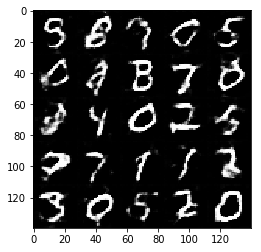

Epoch 1/2... Discriminator Loss: 0.8235... Generator Loss: 1.3372
Epoch 1/2... Discriminator Loss: 0.7130... Generator Loss: 1.0090
Epoch 1/2... Discriminator Loss: 0.9381... Generator Loss: 0.6672
Epoch 1/2... Discriminator Loss: 0.6031... Generator Loss: 2.2508
Epoch 1/2... Discriminator Loss: 0.6803... Generator Loss: 1.8082
Epoch 1/2... Discriminator Loss: 0.9796... Generator Loss: 0.6440
Epoch 1/2... Discriminator Loss: 0.5425... Generator Loss: 1.5381
Epoch 1/2... Discriminator Loss: 1.3456... Generator Loss: 2.7724
Epoch 1/2... Discriminator Loss: 0.9305... Generator Loss: 1.6643
Epoch 1/2... Discriminator Loss: 0.9994... Generator Loss: 0.8739
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


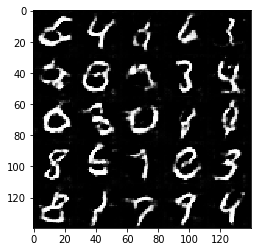

Epoch 1/2... Discriminator Loss: 0.6161... Generator Loss: 1.2153
Epoch 1/2... Discriminator Loss: 0.6094... Generator Loss: 1.0610
Epoch 1/2... Discriminator Loss: 0.7083... Generator Loss: 0.9639
Epoch 1/2... Discriminator Loss: 0.5889... Generator Loss: 1.3312
Epoch 1/2... Discriminator Loss: 0.7715... Generator Loss: 0.9849
Epoch 1/2... Discriminator Loss: 0.5885... Generator Loss: 1.3152
Epoch 1/2... Discriminator Loss: 0.7639... Generator Loss: 1.4793
Epoch 1/2... Discriminator Loss: 0.6751... Generator Loss: 1.1516
Epoch 1/2... Discriminator Loss: 0.7319... Generator Loss: 0.9332
Epoch 1/2... Discriminator Loss: 0.5666... Generator Loss: 2.1877
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


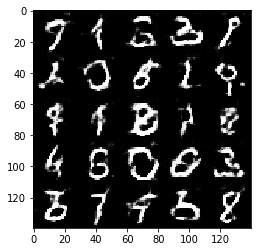

Epoch 1/2... Discriminator Loss: 2.3271... Generator Loss: 0.2176
Epoch 1/2... Discriminator Loss: 0.6780... Generator Loss: 1.2206
Epoch 1/2... Discriminator Loss: 1.1049... Generator Loss: 0.6660
Epoch 1/2... Discriminator Loss: 0.8033... Generator Loss: 0.7830
Epoch 1/2... Discriminator Loss: 1.0935... Generator Loss: 0.8699
Epoch 1/2... Discriminator Loss: 0.5502... Generator Loss: 1.1797
Epoch 1/2... Discriminator Loss: 0.6113... Generator Loss: 1.1799
Epoch 1/2... Discriminator Loss: 0.4961... Generator Loss: 1.4685
Epoch 1/2... Discriminator Loss: 1.2818... Generator Loss: 0.4101
Epoch 1/2... Discriminator Loss: 1.1046... Generator Loss: 0.5813
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


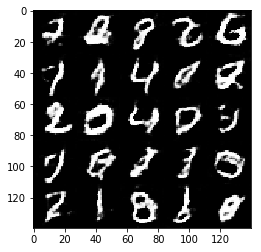

Epoch 1/2... Discriminator Loss: 0.5148... Generator Loss: 1.3235
Epoch 1/2... Discriminator Loss: 0.5561... Generator Loss: 1.2760
Epoch 1/2... Discriminator Loss: 1.0312... Generator Loss: 0.5310
Epoch 1/2... Discriminator Loss: 1.2510... Generator Loss: 0.4540
Epoch 1/2... Discriminator Loss: 0.9992... Generator Loss: 0.6071
Epoch 1/2... Discriminator Loss: 0.5684... Generator Loss: 1.1358
Epoch 1/2... Discriminator Loss: 0.6674... Generator Loss: 0.9361
Epoch 1/2... Discriminator Loss: 1.1606... Generator Loss: 0.4727
Epoch 1/2... Discriminator Loss: 0.7948... Generator Loss: 1.3149
Epoch 1/2... Discriminator Loss: 0.4274... Generator Loss: 1.5999
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


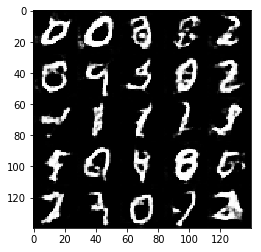

Epoch 1/2... Discriminator Loss: 0.6239... Generator Loss: 1.0711
Epoch 1/2... Discriminator Loss: 0.8207... Generator Loss: 0.8809
Epoch 1/2... Discriminator Loss: 1.0008... Generator Loss: 0.6043
Epoch 1/2... Discriminator Loss: 0.6382... Generator Loss: 1.0408
Epoch 1/2... Discriminator Loss: 1.6300... Generator Loss: 2.7436
Epoch 1/2... Discriminator Loss: 0.3612... Generator Loss: 1.6183
Epoch 1/2... Discriminator Loss: 0.4709... Generator Loss: 1.2482
Epoch 1/2... Discriminator Loss: 1.1466... Generator Loss: 0.4908
Epoch 1/2... Discriminator Loss: 0.8112... Generator Loss: 0.7649
Epoch 1/2... Discriminator Loss: 0.8809... Generator Loss: 0.7265
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


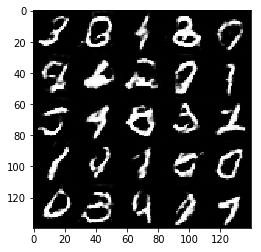

Epoch 1/2... Discriminator Loss: 1.8698... Generator Loss: 0.2319
Epoch 1/2... Discriminator Loss: 1.3425... Generator Loss: 0.4256
Epoch 1/2... Discriminator Loss: 0.9365... Generator Loss: 0.7629
Epoch 1/2... Discriminator Loss: 0.4326... Generator Loss: 1.4741
Epoch 1/2... Discriminator Loss: 0.6321... Generator Loss: 1.0384
Epoch 1/2... Discriminator Loss: 0.6476... Generator Loss: 1.1568
Epoch 1/2... Discriminator Loss: 0.5009... Generator Loss: 1.4048
Epoch 1/2... Discriminator Loss: 0.8222... Generator Loss: 0.9461
Epoch 1/2... Discriminator Loss: 0.7059... Generator Loss: 0.9179
Epoch 1/2... Discriminator Loss: 0.8905... Generator Loss: 0.7100
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


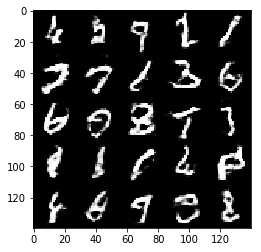

Epoch 1/2... Discriminator Loss: 1.1369... Generator Loss: 0.5457
Epoch 1/2... Discriminator Loss: 0.7167... Generator Loss: 1.0227
Epoch 1/2... Discriminator Loss: 0.5494... Generator Loss: 1.0714
Epoch 1/2... Discriminator Loss: 0.5635... Generator Loss: 1.1465
Epoch 1/2... Discriminator Loss: 0.8881... Generator Loss: 0.6399
Epoch 1/2... Discriminator Loss: 1.3057... Generator Loss: 0.5563
Epoch 1/2... Discriminator Loss: 0.6683... Generator Loss: 1.1844
Epoch 1/2... Discriminator Loss: 0.6558... Generator Loss: 1.0889
Epoch 1/2... Discriminator Loss: 0.5923... Generator Loss: 1.2072
Epoch 1/2... Discriminator Loss: 0.4493... Generator Loss: 1.7090
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


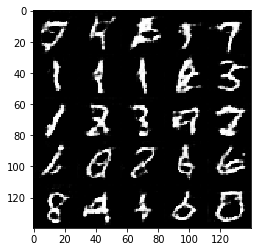

Epoch 1/2... Discriminator Loss: 0.7042... Generator Loss: 1.0491
Epoch 1/2... Discriminator Loss: 0.7098... Generator Loss: 0.9810
Epoch 1/2... Discriminator Loss: 0.5468... Generator Loss: 1.4176
Epoch 1/2... Discriminator Loss: 0.7113... Generator Loss: 0.8711
Epoch 1/2... Discriminator Loss: 0.6575... Generator Loss: 0.9457
Epoch 1/2... Discriminator Loss: 0.7673... Generator Loss: 0.8025
Epoch 1/2... Discriminator Loss: 0.8391... Generator Loss: 0.8500
Epoch 2/2... Discriminator Loss: 4.0199... Generator Loss: 0.0268
Epoch 2/2... Discriminator Loss: 0.6381... Generator Loss: 0.9779
Epoch 2/2... Discriminator Loss: 0.6133... Generator Loss: 1.1436
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


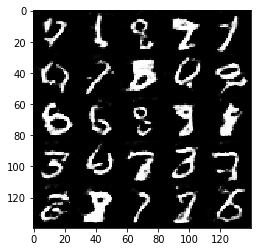

Epoch 2/2... Discriminator Loss: 0.7853... Generator Loss: 0.8873
Epoch 2/2... Discriminator Loss: 1.1297... Generator Loss: 0.4594
Epoch 2/2... Discriminator Loss: 0.6496... Generator Loss: 1.0600
Epoch 2/2... Discriminator Loss: 0.4574... Generator Loss: 1.5076
Epoch 2/2... Discriminator Loss: 0.6967... Generator Loss: 1.0176
Epoch 2/2... Discriminator Loss: 0.7130... Generator Loss: 1.1691
Epoch 2/2... Discriminator Loss: 1.1196... Generator Loss: 0.5204
Epoch 2/2... Discriminator Loss: 0.8536... Generator Loss: 0.7696
Epoch 2/2... Discriminator Loss: 0.5881... Generator Loss: 1.3495
Epoch 2/2... Discriminator Loss: 0.6868... Generator Loss: 0.8611
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


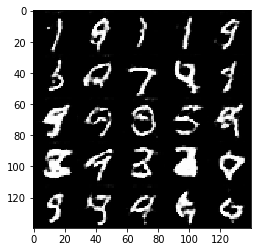

Epoch 2/2... Discriminator Loss: 0.4966... Generator Loss: 1.5352
Epoch 2/2... Discriminator Loss: 0.5099... Generator Loss: 1.4864
Epoch 2/2... Discriminator Loss: 0.8235... Generator Loss: 3.2003
Epoch 2/2... Discriminator Loss: 0.3319... Generator Loss: 2.0878
Epoch 2/2... Discriminator Loss: 1.3334... Generator Loss: 0.4447
Epoch 2/2... Discriminator Loss: 1.3302... Generator Loss: 0.4677
Epoch 2/2... Discriminator Loss: 0.6452... Generator Loss: 1.8689
Epoch 2/2... Discriminator Loss: 0.8571... Generator Loss: 0.7197
Epoch 2/2... Discriminator Loss: 0.7669... Generator Loss: 0.8182
Epoch 2/2... Discriminator Loss: 1.0992... Generator Loss: 0.5590
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


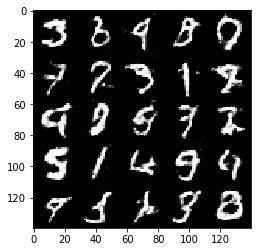

Epoch 2/2... Discriminator Loss: 0.5796... Generator Loss: 1.6223
Epoch 2/2... Discriminator Loss: 0.4490... Generator Loss: 1.8688
Epoch 2/2... Discriminator Loss: 0.4467... Generator Loss: 1.6629
Epoch 2/2... Discriminator Loss: 1.2724... Generator Loss: 0.4404
Epoch 2/2... Discriminator Loss: 0.5778... Generator Loss: 1.2341
Epoch 2/2... Discriminator Loss: 0.6093... Generator Loss: 1.7236
Epoch 2/2... Discriminator Loss: 0.7249... Generator Loss: 0.9014
Epoch 2/2... Discriminator Loss: 0.8426... Generator Loss: 0.7505
Epoch 2/2... Discriminator Loss: 0.4212... Generator Loss: 1.7768
Epoch 2/2... Discriminator Loss: 0.6960... Generator Loss: 1.1145
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


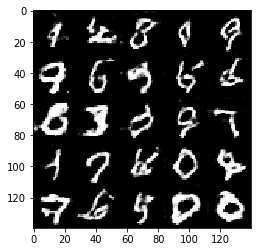

Epoch 2/2... Discriminator Loss: 0.5166... Generator Loss: 1.3754
Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 0.7635
Epoch 2/2... Discriminator Loss: 1.0481... Generator Loss: 0.5791
Epoch 2/2... Discriminator Loss: 0.6513... Generator Loss: 0.9520
Epoch 2/2... Discriminator Loss: 0.6294... Generator Loss: 1.0924
Epoch 2/2... Discriminator Loss: 0.5136... Generator Loss: 1.2609
Epoch 2/2... Discriminator Loss: 0.5820... Generator Loss: 2.4317
Epoch 2/2... Discriminator Loss: 0.6398... Generator Loss: 2.0406
Epoch 2/2... Discriminator Loss: 0.4570... Generator Loss: 1.4555
Epoch 2/2... Discriminator Loss: 0.6235... Generator Loss: 1.8666
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


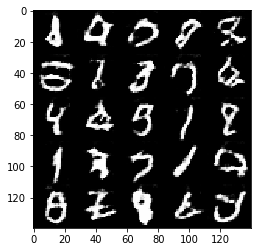

Epoch 2/2... Discriminator Loss: 1.3910... Generator Loss: 0.3567
Epoch 2/2... Discriminator Loss: 0.3547... Generator Loss: 2.8121
Epoch 2/2... Discriminator Loss: 0.8842... Generator Loss: 0.7102
Epoch 2/2... Discriminator Loss: 0.3816... Generator Loss: 1.6441
Epoch 2/2... Discriminator Loss: 0.6255... Generator Loss: 1.1855
Epoch 2/2... Discriminator Loss: 1.0759... Generator Loss: 0.5986
Epoch 2/2... Discriminator Loss: 0.5353... Generator Loss: 1.2529
Epoch 2/2... Discriminator Loss: 1.1279... Generator Loss: 0.4976
Epoch 2/2... Discriminator Loss: 1.0430... Generator Loss: 0.5603
Epoch 2/2... Discriminator Loss: 0.4756... Generator Loss: 1.6114
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


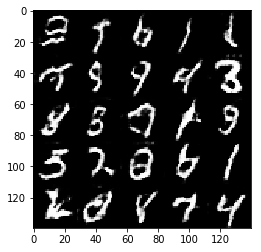

Epoch 2/2... Discriminator Loss: 0.5047... Generator Loss: 1.2714
Epoch 2/2... Discriminator Loss: 0.4293... Generator Loss: 1.6970
Epoch 2/2... Discriminator Loss: 1.1366... Generator Loss: 0.5529
Epoch 2/2... Discriminator Loss: 0.6648... Generator Loss: 0.9527
Epoch 2/2... Discriminator Loss: 0.5249... Generator Loss: 1.3467
Epoch 2/2... Discriminator Loss: 1.6430... Generator Loss: 0.3277
Epoch 2/2... Discriminator Loss: 0.7885... Generator Loss: 1.5342
Epoch 2/2... Discriminator Loss: 0.8783... Generator Loss: 0.8207
Epoch 2/2... Discriminator Loss: 0.8575... Generator Loss: 0.7863
Epoch 2/2... Discriminator Loss: 0.8363... Generator Loss: 0.7205
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


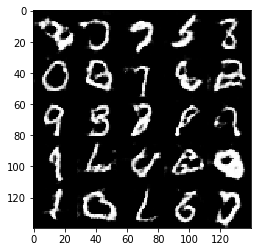

Epoch 2/2... Discriminator Loss: 1.0821... Generator Loss: 0.5601
Epoch 2/2... Discriminator Loss: 0.4581... Generator Loss: 2.1470
Epoch 2/2... Discriminator Loss: 1.0954... Generator Loss: 0.6000
Epoch 2/2... Discriminator Loss: 0.8865... Generator Loss: 0.7678
Epoch 2/2... Discriminator Loss: 1.5079... Generator Loss: 0.4240
Epoch 2/2... Discriminator Loss: 0.5471... Generator Loss: 1.5638
Epoch 2/2... Discriminator Loss: 0.5086... Generator Loss: 1.5594
Epoch 2/2... Discriminator Loss: 0.4383... Generator Loss: 1.9027
Epoch 2/2... Discriminator Loss: 0.4149... Generator Loss: 1.6645
Epoch 2/2... Discriminator Loss: 0.4607... Generator Loss: 1.6348
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


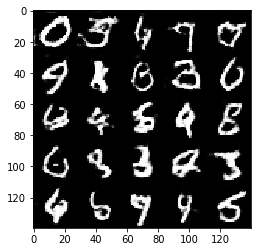

Epoch 2/2... Discriminator Loss: 0.2974... Generator Loss: 2.0435
Epoch 2/2... Discriminator Loss: 0.7454... Generator Loss: 0.8625
Epoch 2/2... Discriminator Loss: 0.8111... Generator Loss: 0.8091
Epoch 2/2... Discriminator Loss: 0.5577... Generator Loss: 1.1083
Epoch 2/2... Discriminator Loss: 0.6176... Generator Loss: 1.0455
Epoch 2/2... Discriminator Loss: 3.0874... Generator Loss: 6.3594
Epoch 2/2... Discriminator Loss: 1.1337... Generator Loss: 0.5823
Epoch 2/2... Discriminator Loss: 0.6431... Generator Loss: 1.1733
Epoch 2/2... Discriminator Loss: 0.7296... Generator Loss: 0.9042
Epoch 2/2... Discriminator Loss: 0.4691... Generator Loss: 1.9664
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


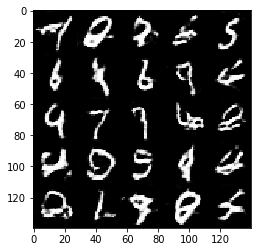

Epoch 2/2... Discriminator Loss: 0.8787... Generator Loss: 0.9494
Epoch 2/2... Discriminator Loss: 0.5825... Generator Loss: 1.1901
Epoch 2/2... Discriminator Loss: 0.6668... Generator Loss: 0.9685
Epoch 2/2... Discriminator Loss: 0.6909... Generator Loss: 0.9024
Epoch 2/2... Discriminator Loss: 0.7028... Generator Loss: 1.0494
Epoch 2/2... Discriminator Loss: 0.4247... Generator Loss: 2.7017
Epoch 2/2... Discriminator Loss: 0.6496... Generator Loss: 1.0294
Epoch 2/2... Discriminator Loss: 0.5192... Generator Loss: 1.1353
Epoch 2/2... Discriminator Loss: 0.5654... Generator Loss: 1.1507
Epoch 2/2... Discriminator Loss: 0.3956... Generator Loss: 1.5943
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


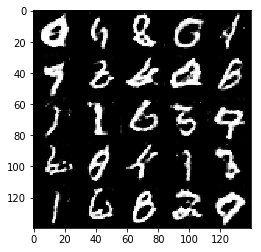

Epoch 2/2... Discriminator Loss: 0.6472... Generator Loss: 1.1488
Epoch 2/2... Discriminator Loss: 0.2726... Generator Loss: 2.7866
Epoch 2/2... Discriminator Loss: 0.8751... Generator Loss: 0.7960
Epoch 2/2... Discriminator Loss: 0.8617... Generator Loss: 0.7664
Epoch 2/2... Discriminator Loss: 0.4128... Generator Loss: 1.5154
Epoch 2/2... Discriminator Loss: 0.5575... Generator Loss: 1.5604
Epoch 2/2... Discriminator Loss: 1.0282... Generator Loss: 0.5658
Epoch 2/2... Discriminator Loss: 0.2863... Generator Loss: 2.1591
Epoch 2/2... Discriminator Loss: 0.8607... Generator Loss: 0.7076
Epoch 2/2... Discriminator Loss: 0.6158... Generator Loss: 1.0677
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


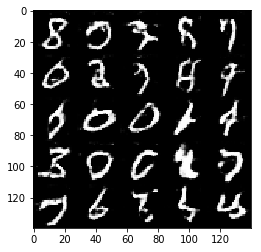

Epoch 2/2... Discriminator Loss: 1.1405... Generator Loss: 0.5207
Epoch 2/2... Discriminator Loss: 0.5219... Generator Loss: 1.2802
Epoch 2/2... Discriminator Loss: 0.5853... Generator Loss: 1.0563
Epoch 2/2... Discriminator Loss: 0.8887... Generator Loss: 0.6988
Epoch 2/2... Discriminator Loss: 0.7576... Generator Loss: 1.0323
Epoch 2/2... Discriminator Loss: 0.7799... Generator Loss: 0.9159
Epoch 2/2... Discriminator Loss: 0.6037... Generator Loss: 1.2902
Epoch 2/2... Discriminator Loss: 0.5269... Generator Loss: 1.3704
Epoch 2/2... Discriminator Loss: 0.3467... Generator Loss: 1.7891
Epoch 2/2... Discriminator Loss: 0.3889... Generator Loss: 1.5502
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


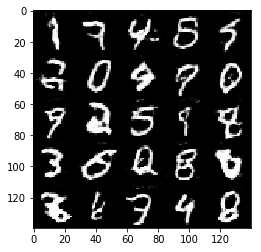

Epoch 2/2... Discriminator Loss: 0.4456... Generator Loss: 1.5595
Epoch 2/2... Discriminator Loss: 0.5994... Generator Loss: 1.0656
Epoch 2/2... Discriminator Loss: 0.5595... Generator Loss: 1.1152
Epoch 2/2... Discriminator Loss: 0.5865... Generator Loss: 1.0592
Epoch 2/2... Discriminator Loss: 0.6444... Generator Loss: 3.1575
Epoch 2/2... Discriminator Loss: 1.0566... Generator Loss: 0.5765
Epoch 2/2... Discriminator Loss: 1.0998... Generator Loss: 0.6501
Epoch 2/2... Discriminator Loss: 1.0704... Generator Loss: 0.6777
Epoch 2/2... Discriminator Loss: 0.3802... Generator Loss: 2.4962
Epoch 2/2... Discriminator Loss: 0.3814... Generator Loss: 1.4187
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


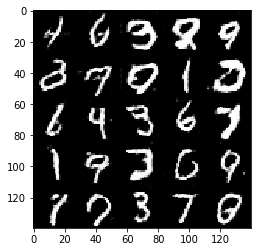

Epoch 2/2... Discriminator Loss: 0.6958... Generator Loss: 0.8890
Epoch 2/2... Discriminator Loss: 0.8823... Generator Loss: 0.6988
Epoch 2/2... Discriminator Loss: 0.4993... Generator Loss: 1.3991
Epoch 2/2... Discriminator Loss: 0.4629... Generator Loss: 1.2748
Epoch 2/2... Discriminator Loss: 0.5979... Generator Loss: 1.3402
Epoch 2/2... Discriminator Loss: 0.5910... Generator Loss: 1.3413
Epoch 2/2... Discriminator Loss: 1.2031... Generator Loss: 0.5895
Epoch 2/2... Discriminator Loss: 0.3203... Generator Loss: 1.6914
Epoch 2/2... Discriminator Loss: 0.7761... Generator Loss: 0.9482
Epoch 2/2... Discriminator Loss: 0.7027... Generator Loss: 0.9130
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


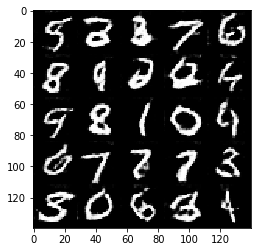

Epoch 2/2... Discriminator Loss: 0.8491... Generator Loss: 0.7115
Epoch 2/2... Discriminator Loss: 0.9362... Generator Loss: 0.7996
Epoch 2/2... Discriminator Loss: 0.7107... Generator Loss: 0.9096
Epoch 2/2... Discriminator Loss: 0.9220... Generator Loss: 0.7389
Epoch 2/2... Discriminator Loss: 0.2885... Generator Loss: 2.6943
Epoch 2/2... Discriminator Loss: 0.2564... Generator Loss: 1.9695
Epoch 2/2... Discriminator Loss: 0.3513... Generator Loss: 1.7498
Epoch 2/2... Discriminator Loss: 0.3779... Generator Loss: 2.3411
Epoch 2/2... Discriminator Loss: 0.4975... Generator Loss: 1.8815
Epoch 2/2... Discriminator Loss: 0.5609... Generator Loss: 1.9207
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


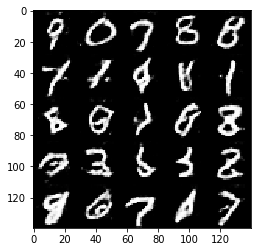

Epoch 2/2... Discriminator Loss: 0.5561... Generator Loss: 2.0855
Epoch 2/2... Discriminator Loss: 0.4807... Generator Loss: 1.4077
Epoch 2/2... Discriminator Loss: 0.5131... Generator Loss: 1.2878
Epoch 2/2... Discriminator Loss: 0.9943... Generator Loss: 0.6681
Epoch 2/2... Discriminator Loss: 0.4651... Generator Loss: 1.3267
Epoch 2/2... Discriminator Loss: 0.4584... Generator Loss: 1.5239
Epoch 2/2... Discriminator Loss: 0.3274... Generator Loss: 1.6978
Epoch 2/2... Discriminator Loss: 0.4792... Generator Loss: 1.3004
Epoch 2/2... Discriminator Loss: 0.3964... Generator Loss: 1.7245
Epoch 2/2... Discriminator Loss: 0.2750... Generator Loss: 1.7592
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


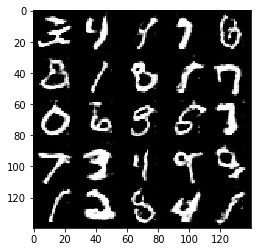

Epoch 2/2... Discriminator Loss: 1.5885... Generator Loss: 0.3308
Epoch 2/2... Discriminator Loss: 0.6530... Generator Loss: 3.1166
Epoch 2/2... Discriminator Loss: 0.4944... Generator Loss: 1.4040
Epoch 2/2... Discriminator Loss: 0.4572... Generator Loss: 1.5357
Epoch 2/2... Discriminator Loss: 0.8170... Generator Loss: 0.8330
Epoch 2/2... Discriminator Loss: 0.4511... Generator Loss: 1.4645
Epoch 2/2... Discriminator Loss: 1.3587... Generator Loss: 0.4374
Epoch 2/2... Discriminator Loss: 0.5948... Generator Loss: 1.1300
Epoch 2/2... Discriminator Loss: 0.2931... Generator Loss: 1.9530
Epoch 2/2... Discriminator Loss: 0.6164... Generator Loss: 1.1728
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


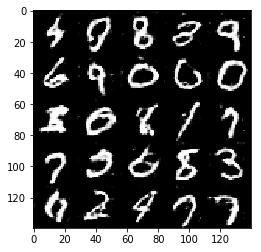

Epoch 2/2... Discriminator Loss: 0.4742... Generator Loss: 1.5922
Epoch 2/2... Discriminator Loss: 0.4868... Generator Loss: 2.0017
Epoch 2/2... Discriminator Loss: 0.8323... Generator Loss: 0.8380
Epoch 2/2... Discriminator Loss: 0.9213... Generator Loss: 0.7584
Epoch 2/2... Discriminator Loss: 0.4656... Generator Loss: 2.0448
Epoch 2/2... Discriminator Loss: 1.0316... Generator Loss: 0.5695
Epoch 2/2... Discriminator Loss: 0.2805... Generator Loss: 1.8196
Epoch 2/2... Discriminator Loss: 0.7830... Generator Loss: 0.8876
Epoch 2/2... Discriminator Loss: 0.5833... Generator Loss: 1.2083
Epoch 2/2... Discriminator Loss: 0.4151... Generator Loss: 1.5132
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


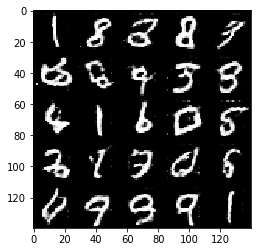

Epoch 2/2... Discriminator Loss: 0.4982... Generator Loss: 1.3044
Epoch 2/2... Discriminator Loss: 0.3021... Generator Loss: 1.6933
Epoch 2/2... Discriminator Loss: 0.5619... Generator Loss: 2.6866
Epoch 2/2... Discriminator Loss: 0.9543... Generator Loss: 0.6786
Epoch 2/2... Discriminator Loss: 1.2735... Generator Loss: 0.4729
Epoch 2/2... Discriminator Loss: 0.6900... Generator Loss: 0.9969
Epoch 2/2... Discriminator Loss: 1.0347... Generator Loss: 0.6652
Epoch 2/2... Discriminator Loss: 1.2016... Generator Loss: 0.5601
Epoch 2/2... Discriminator Loss: 0.3998... Generator Loss: 1.6368
Epoch 2/2... Discriminator Loss: 0.7343... Generator Loss: 0.9015
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


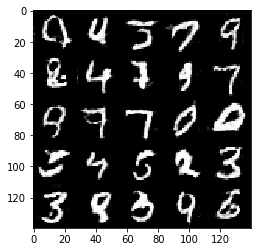

Epoch 2/2... Discriminator Loss: 1.1208... Generator Loss: 0.5409
Epoch 2/2... Discriminator Loss: 0.3937... Generator Loss: 1.8120
Epoch 2/2... Discriminator Loss: 1.2917... Generator Loss: 0.4010
Epoch 2/2... Discriminator Loss: 1.0862... Generator Loss: 0.6046
Epoch 2/2... Discriminator Loss: 0.2113... Generator Loss: 2.0580


In [77]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

100
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)
(?, 4, 4, 256)
(?, 4, 4, 256)
Tensor("discriminator/Sigmoid:0", shape=(?, 1), dtype=float32)
Epoch 1/1... Discriminator Loss: 0.6960... Generator Loss: 0.9510
Epoch 1/1... Discriminator Loss: 0.4119... Generator Loss: 1.4440
Epoch 1/1... Discriminator Loss: 0.5130... Generator Loss: 1.0306
Epoch 1/1... Discriminator Loss: 0.0523... Generator Loss: 5.9912
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.3507
Epoch 1/1... Discriminator Loss: 0.2060... Generator Loss: 3.2535
Epoch 1/1... Discriminator Loss: 0.1053... Generator Loss: 3.3786
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 5.4441
Epoch 1/1... Discriminator Loss: 4.1624... Generator Loss: 0.0339
Epoch 1/1... Discriminator Loss: 0.1808... Generator Loss: 5.9298
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


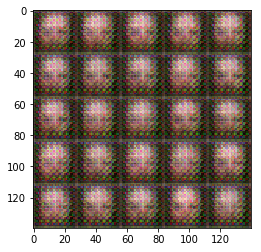

Epoch 1/1... Discriminator Loss: 0.7668... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 0.2112... Generator Loss: 2.5994
Epoch 1/1... Discriminator Loss: 0.5884... Generator Loss: 1.2873
Epoch 1/1... Discriminator Loss: 0.2366... Generator Loss: 2.4316
Epoch 1/1... Discriminator Loss: 0.2154... Generator Loss: 2.6488
Epoch 1/1... Discriminator Loss: 0.4477... Generator Loss: 1.4103
Epoch 1/1... Discriminator Loss: 0.1949... Generator Loss: 2.3151
Epoch 1/1... Discriminator Loss: 0.3079... Generator Loss: 2.1871
Epoch 1/1... Discriminator Loss: 0.1443... Generator Loss: 3.4824
Epoch 1/1... Discriminator Loss: 0.1087... Generator Loss: 2.7052
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


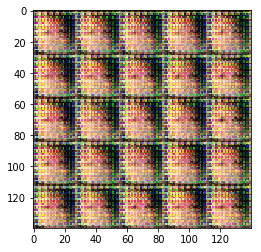

Epoch 1/1... Discriminator Loss: 0.1345... Generator Loss: 2.6992
Epoch 1/1... Discriminator Loss: 0.2487... Generator Loss: 1.9708
Epoch 1/1... Discriminator Loss: 0.1202... Generator Loss: 2.8598
Epoch 1/1... Discriminator Loss: 0.1172... Generator Loss: 3.1337
Epoch 1/1... Discriminator Loss: 0.0891... Generator Loss: 3.3394
Epoch 1/1... Discriminator Loss: 0.0824... Generator Loss: 3.2955
Epoch 1/1... Discriminator Loss: 0.0998... Generator Loss: 3.5312
Epoch 1/1... Discriminator Loss: 0.2149... Generator Loss: 2.1940
Epoch 1/1... Discriminator Loss: 0.1388... Generator Loss: 3.0617
Epoch 1/1... Discriminator Loss: 0.0824... Generator Loss: 3.1746
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


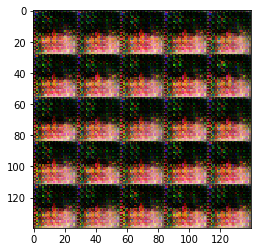

Epoch 1/1... Discriminator Loss: 0.0932... Generator Loss: 3.1703
Epoch 1/1... Discriminator Loss: 0.0840... Generator Loss: 3.4158
Epoch 1/1... Discriminator Loss: 0.1986... Generator Loss: 2.5413
Epoch 1/1... Discriminator Loss: 0.2434... Generator Loss: 1.9817
Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 0.2398... Generator Loss: 2.9121
Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 6.5325
Epoch 1/1... Discriminator Loss: 0.2762... Generator Loss: 3.0609
Epoch 1/1... Discriminator Loss: 0.6468... Generator Loss: 1.5257
Epoch 1/1... Discriminator Loss: 0.3405... Generator Loss: 1.8248
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


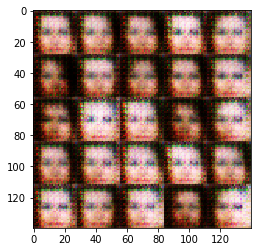

Epoch 1/1... Discriminator Loss: 0.5813... Generator Loss: 1.9251
Epoch 1/1... Discriminator Loss: 0.3127... Generator Loss: 3.7384
Epoch 1/1... Discriminator Loss: 0.7481... Generator Loss: 1.3144
Epoch 1/1... Discriminator Loss: 0.6663... Generator Loss: 3.6706
Epoch 1/1... Discriminator Loss: 0.3842... Generator Loss: 2.4045
Epoch 1/1... Discriminator Loss: 0.3033... Generator Loss: 1.9419
Epoch 1/1... Discriminator Loss: 0.4826... Generator Loss: 2.1341
Epoch 1/1... Discriminator Loss: 0.4141... Generator Loss: 2.2852
Epoch 1/1... Discriminator Loss: 1.6909... Generator Loss: 0.3415
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 5.1456
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


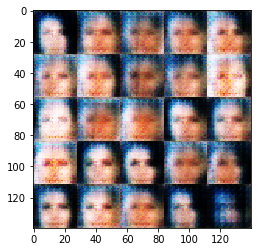

Epoch 1/1... Discriminator Loss: 0.5376... Generator Loss: 1.5592
Epoch 1/1... Discriminator Loss: 0.5774... Generator Loss: 1.7317
Epoch 1/1... Discriminator Loss: 0.5350... Generator Loss: 1.6261
Epoch 1/1... Discriminator Loss: 0.3608... Generator Loss: 2.4259
Epoch 1/1... Discriminator Loss: 1.7900... Generator Loss: 0.3750
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 2.3964
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 2.5843
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.4531
Epoch 1/1... Discriminator Loss: 0.6753... Generator Loss: 1.5034
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 0.6323
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


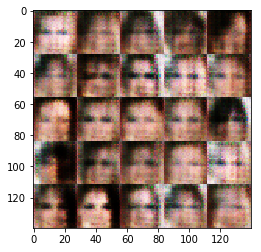

Epoch 1/1... Discriminator Loss: 0.6274... Generator Loss: 1.8085
Epoch 1/1... Discriminator Loss: 0.5618... Generator Loss: 1.9042
Epoch 1/1... Discriminator Loss: 0.9400... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 0.7319... Generator Loss: 1.3329
Epoch 1/1... Discriminator Loss: 0.7454... Generator Loss: 1.2133
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 1.0422
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 1.7726
Epoch 1/1... Discriminator Loss: 0.8736... Generator Loss: 1.5656
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 2.3544
Epoch 1/1... Discriminator Loss: 0.8640... Generator Loss: 1.1277
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


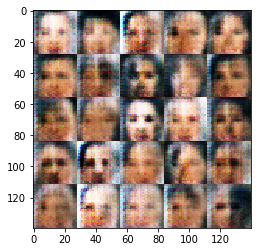

Epoch 1/1... Discriminator Loss: 0.7134... Generator Loss: 1.1708
Epoch 1/1... Discriminator Loss: 0.5598... Generator Loss: 2.0402
Epoch 1/1... Discriminator Loss: 0.7958... Generator Loss: 1.6231
Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 0.5287... Generator Loss: 1.8948
Epoch 1/1... Discriminator Loss: 0.7342... Generator Loss: 1.5496
Epoch 1/1... Discriminator Loss: 0.8235... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 0.8328
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


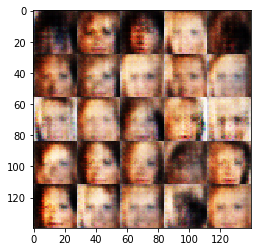

Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 1.8460
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 0.7692... Generator Loss: 1.1641
Epoch 1/1... Discriminator Loss: 0.8183... Generator Loss: 1.2701
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 0.8657... Generator Loss: 1.5934
Epoch 1/1... Discriminator Loss: 0.7644... Generator Loss: 1.3981
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 1.9730
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 1.1341
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


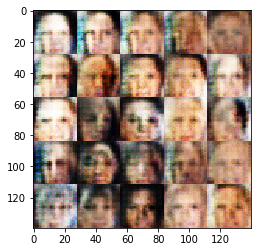

Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 1.3623
Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 1.3405
Epoch 1/1... Discriminator Loss: 0.7793... Generator Loss: 1.5191
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.9333
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 1.3060
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 0.7493
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


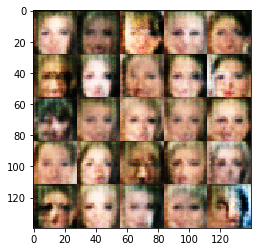

Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 1.1554
Epoch 1/1... Discriminator Loss: 0.8754... Generator Loss: 1.1322
Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 0.5890
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 1.3728
Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 1.2722
Epoch 1/1... Discriminator Loss: 0.9147... Generator Loss: 2.2233
Epoch 1/1... Discriminator Loss: 1.0167... Generator Loss: 1.2183
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 1.0540
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


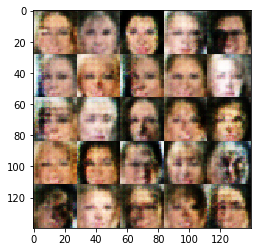

Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 1.6931
Epoch 1/1... Discriminator Loss: 0.8282... Generator Loss: 1.5389
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 1.3252
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 0.8606... Generator Loss: 1.2794
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 0.8397
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


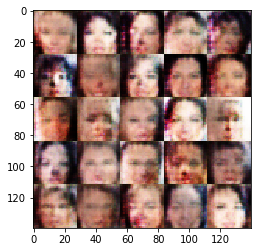

Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 0.9727... Generator Loss: 0.9775
Epoch 1/1... Discriminator Loss: 0.9991... Generator Loss: 1.2449
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 0.9052
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 1.3185
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 1.4349
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 1.7266
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


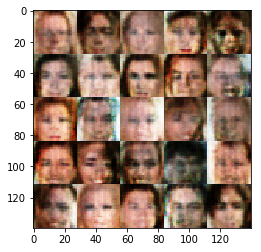

Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 1.2158
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 1.1972
Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 1.0524
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 1.2245
Epoch 1/1... Discriminator Loss: 0.9421... Generator Loss: 1.7718
Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 0.9186
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


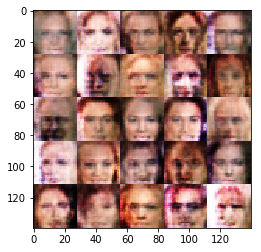

Epoch 1/1... Discriminator Loss: 0.8842... Generator Loss: 1.0828
Epoch 1/1... Discriminator Loss: 1.0032... Generator Loss: 1.2847
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.4311
Epoch 1/1... Discriminator Loss: 0.8560... Generator Loss: 1.0024
Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 1.2713
Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 0.8503... Generator Loss: 1.3365
Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 0.8909
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 0.7631... Generator Loss: 1.3319
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


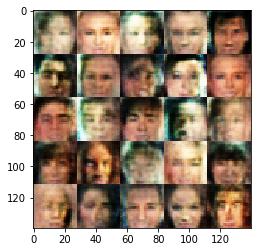

Epoch 1/1... Discriminator Loss: 0.8102... Generator Loss: 1.0943
Epoch 1/1... Discriminator Loss: 1.5568... Generator Loss: 0.3371
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 1.0654
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 1.1758
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 0.8042
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


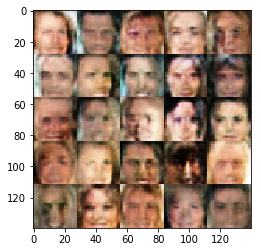

Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 0.9954
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.9149
Epoch 1/1... Discriminator Loss: 0.9003... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 0.6756... Generator Loss: 1.5344
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 1.6309
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 1.3722
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 0.7714
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


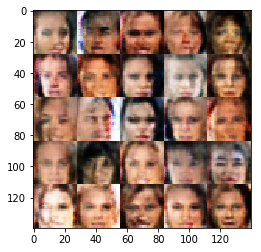

Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 1.4276
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 1.4034
Epoch 1/1... Discriminator Loss: 0.7249... Generator Loss: 0.9902
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 0.8044... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 1.0057
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 0.8032
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


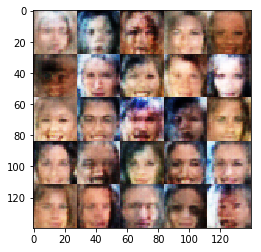

Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 1.0779
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 0.9836
Epoch 1/1... Discriminator Loss: 0.7708... Generator Loss: 1.3041
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.4671
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.0100... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 0.8178... Generator Loss: 1.1197
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.8944
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


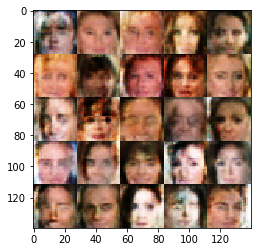

Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 1.4529
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 0.9342... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.4992
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 0.8803
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


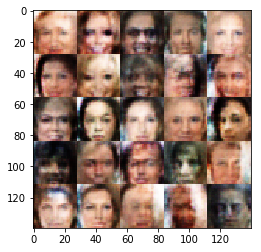

Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 1.1656
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 0.9452... Generator Loss: 1.1465
Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 0.8764... Generator Loss: 1.0968
Epoch 1/1... Discriminator Loss: 0.9118... Generator Loss: 1.1320
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 0.5457
Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 1.0697
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


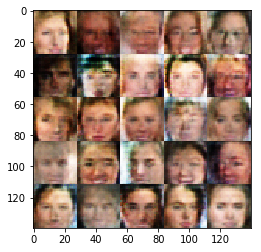

Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 1.4415
Epoch 1/1... Discriminator Loss: 1.0368... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 0.8995... Generator Loss: 1.1033
Epoch 1/1... Discriminator Loss: 0.8863... Generator Loss: 1.0785
Epoch 1/1... Discriminator Loss: 0.8167... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 1.3962
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.3600
Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 0.9855
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


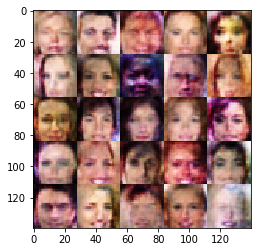

Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 0.9258
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 0.9754
Epoch 1/1... Discriminator Loss: 0.6032... Generator Loss: 1.5262
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 0.9378
Epoch 1/1... Discriminator Loss: 0.9580... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 0.7264... Generator Loss: 1.4690
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 1.2041
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


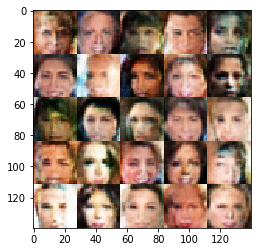

Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 1.5456
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 0.9665
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.5342
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.4546
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.4897
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 0.6624... Generator Loss: 1.1419
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 0.7090... Generator Loss: 1.3842
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.6350
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


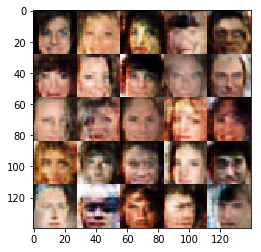

Epoch 1/1... Discriminator Loss: 0.8505... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 0.8841... Generator Loss: 1.0831
Epoch 1/1... Discriminator Loss: 0.9663... Generator Loss: 0.9503
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 0.8604... Generator Loss: 1.0980
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.3907
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.4327
Epoch 1/1... Discriminator Loss: 0.8125... Generator Loss: 1.1624
Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 0.8829
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


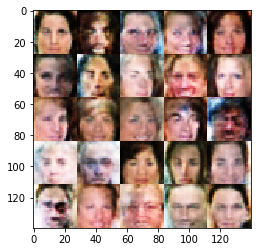

Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 1.3389
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 1.1865
Epoch 1/1... Discriminator Loss: 0.5943... Generator Loss: 1.3938
Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 0.7982... Generator Loss: 1.3057
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 0.8085... Generator Loss: 1.1476
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.5163
Epoch 1/1... Discriminator Loss: 0.9193... Generator Loss: 0.8659
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


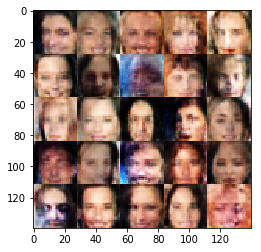

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.